Note: tutorial notebooks on training a mouse cortex CREsted model and on doing a complete enhancer code analysis are available in the main CREsted repository:
- model_training_and_eval.ipynb
- enhancer_code_analysis.ipynb

# DeepBICCN2 analysis
A GPU is recommended throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42  
matplotlib.rcParams["ps.fonttype"] = 42  
from pathlib import Path
import anndata

2025-03-14 13:24:04.298260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 13:24:04.334662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 13:24:06.733929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [2]:
DATA_DIR ="../../../crested_data/Figure_2/"

## Load mm10 genome

This notebook requires an mm10 fasta file and an mm10 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html 
Once downloaded, we load them to the notebook.

In [3]:
genome_dir = "../../../mouse/biccn/"
genome_fasta = f"{genome_dir}mm10.fa"
genome_chrom_sizes  = f"{genome_dir}mm10.chrom.sizes" 

In [4]:
genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

2025-03-14T13:24:16.792324+0100 INFO Genome mm10 registered.


## Load DeepBICCN2 and DeepBICCN2 basemodel

In [5]:
bigwigs_folder = f"{DATA_DIR}cut_sites_bws/" # From Zemke et al., 2023, processed with pycistopic (Johansen & Kempynck et al., 2024)
regions_file = f"{DATA_DIR}consensus_regions.bed"

In [6]:
adata = anndata.read_h5ad(f"{DATA_DIR}mouse_cortex_filtered.h5ad")
adata_base = anndata.read_h5ad(f"{DATA_DIR}mouse_cortex.h5ad")

In [7]:
model_path =f"{DATA_DIR}DeepBICCN2.keras"
model = keras.models.load_model(
    model_path, compile=False
)

2025-03-14 13:24:18.719563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78783 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:d2:00.0, compute capability: 9.0


In [8]:
model_path =f"{DATA_DIR}DeepBICCN2_basemodel.keras"
basemodel = keras.models.load_model(
    model_path, compile=False
)

The predictions are already stored in the adata layers. If you want to recalculate them (takes some time), rerun the two cells below.

In [9]:
#predictions = crested.tl.predict(adata, model)
#adata.layers["DeepBICCN2"] = predictions.T  
#predictions_base = crested.tl.predict(adata, basemodel)
#adata.layers["DeepBICCN2_base"] = predictions_base.T

In [10]:
#predictions = crested.tl.predict(adata_base, model)
#adata_base.layers["DeepBICCN2"] = predictions.T  
#predictions_base = crested.tl.predict(adata_base, basemodel)
#adata_base.layers["DeepBICCN2_base"] = predictions_base.T

In [11]:
adata.layers

Layers with keys: DeepBICCN2, DeepBICCN2_base, gReLU_22M, gReLU_6M

### Load gReLU predictions
The gReLU models can be found in the DATA_DIR.

In [12]:
grelu_preds = np.load(f'{DATA_DIR}grelu/grelu_preds_crested_testregs.npy')
adata.layers['gReLU_6M'] = grelu_preds.T
grelu_preds = np.load(f'{DATA_DIR}grelu/grelu_big_preds_crested_testregs.npy')
adata.layers['gReLU_22M'] = grelu_preds.T

In [13]:
grelu_preds = np.load(f'{DATA_DIR}grelu/grelu_preds_all_crested_testregs.npy')
adata_base.layers['gReLU_6M'] = grelu_preds.T
grelu_preds = np.load(f'{DATA_DIR}grelu/grelu_big_preds_all_crested_testregs.npy')
adata_base.layers['gReLU_22M'] = grelu_preds.T

## Model predictions

### Fig. 2b

2025-03-14T13:24:19.817277+0100 INFO Plotting density scatter for all targets and predictions, models: ['DeepBICCN2'], split: test


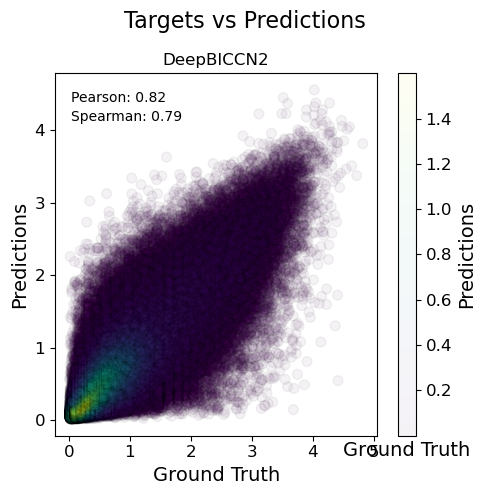

In [14]:
crested.pl.scatter.class_density(
    adata,
    model_names=['DeepBICCN2'],
    split="test",
    log_transform=True,
    width=5,
    height=5,
    density_indication=True,
    alpha=0.05,
    #save_path='paperfigs/all_preds_scatter.pdf'
)

### Fig. 2c

2025-03-14T13:26:19.013194+0100 INFO Plotting heatmap correlations for split: test, models: ['DeepBICCN2']


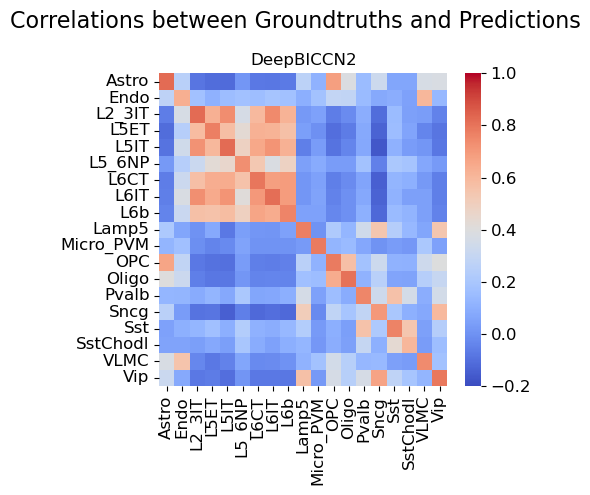

In [15]:
crested.pl.heatmap.correlations_predictions(
    adata,
    model_names=['DeepBICCN2'],
    split="test",
    title="Correlations between Groundtruths and Predictions",
    x_label_rotation=90,
    width=5,
    height=5,
    log_transform=True,
    vmax=1,
    vmin=-0.2,
    #save_path='paperfigs/heatmap.pdf'
)

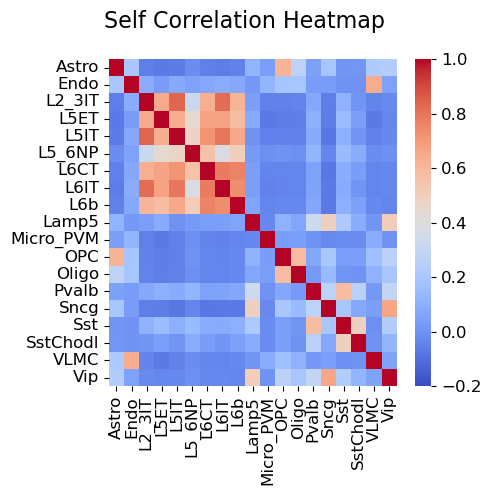

In [16]:
crested.pl.heatmap.correlations_self(
    adata, title="Self Correlation Heatmap", x_label_rotation=90, width=5, height=5, vmax=1, vmin=-0.2#, save_path='paperfigs/self_corr.pdf'
)

### DeepBICCN2, DeepBICCN2_basemodel and gReLU comparisons

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity

# Filter for 'test' indices
test_indices = np.where(adata.var['split'] == 'test')[0]

# Extract ground truth for test set
ground_truth = adata.X.T[test_indices, :]

# Prepare results dictionary
metrics_results = {}

# Loop over prediction keys in adata.layers
for key in adata.layers.keys():
    predictions = adata.layers[key].T[test_indices, :]
    
    # Flatten arrays to ensure compatibility with metrics
    ground_truth_flat = ground_truth.flatten()
    predictions_flat = predictions.flatten()

    # Log1p-transform the ground truth and predictions
    ground_truth_log1p = np.log1p(ground_truth_flat)
    predictions_log1p = np.log1p(predictions_flat)

    # Calculate average cosine similarity per sample
    sample_cosine_similarities = []
    for gt_row, pred_row in zip(ground_truth, predictions):
        similarity = cosine_similarity(gt_row.reshape(1, -1), pred_row.reshape(1, -1))[0, 0]
        sample_cosine_similarities.append(similarity)
    avg_cosine_similarity = np.mean(sample_cosine_similarities)

    # Calculate metrics
    metrics_results[key] = {
        'Pearson Correlation': pearsonr(ground_truth_flat, predictions_flat)[0],
        'Pearson Correlation (log)': pearsonr(ground_truth_log1p, predictions_log1p)[0],
        'Spearman Correlation': spearmanr(ground_truth_flat, predictions_flat).correlation,
        'Normalized RMSE': np.sqrt(np.mean((ground_truth_flat - predictions_flat)**2)) / np.mean(ground_truth_flat),
        'SMAPE': np.mean(2 * np.abs(predictions_flat - ground_truth_flat) / 
                         (np.abs(predictions_flat) + np.abs(ground_truth_flat))) * 100,
        'Average Cosine Similarity': avg_cosine_similarity
    }

# Convert metrics results to a DataFrame for readability
metrics_df = pd.DataFrame(metrics_results).T

metrics_df # For cell type-specific peaks

,Pearson Correlation,Pearson Correlation (log),Spearman Correlation,Normalized RMSE,SMAPE,Average Cosine Similarity
DeepBICCN2,0.781337,0.821724,0.785320,1.203346,71.729165,0.870675
DeepBICCN2_base,0.754724,0.803695,0.770478,1.280129,71.461892,0.857459
gReLU_22M,0.513015,0.629100,0.646404,1.617502,84.081089,0.732813
gReLU_6M,0.466871,0.616384,0.641363,1.661574,86.079162,0.719202


In [18]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_correlations(adata):
    # Get test indices
    test_indices = np.where(adata.var['split'] == 'test')[0]
    ground_truth = adata.X.T[test_indices, :]

    # Prepare a dictionary to store results
    class_metrics = {}
    classes = list(adata.obs_names)

    # Loop over prediction keys in adata.layers
    for key in adata.layers.keys():
        predictions = adata.layers[key].T[test_indices, :]  # Shape: (#samples, #classes)
        class_metrics[key] = {}

        # Loop over each class (column in predictions)
        for class_idx in range(predictions.shape[1]):
            # Extract ground truth and predictions for the current class
            ground_truth_class = ground_truth[:, class_idx]
            predictions_class = predictions[:, class_idx]

            # Compute Pearson and Spearman correlations for the current class
            pearson_corr = pearsonr(ground_truth_class, predictions_class)[0]
            pearson_corr_log = pearsonr(np.log1p(ground_truth_class), np.log1p(predictions_class))[0]
            spearman_corr = spearmanr(ground_truth_class, predictions_class).correlation

            # Store the results
            class_metrics[key][classes[class_idx]] = {
                'Pearson Correlation': pearson_corr,
                'Pearson Correlation (log)': pearson_corr_log,
                'Spearman Correlation': spearman_corr
            }

    # Convert class metrics into a DataFrame for better readability
    class_metrics_df = {}

    for model_name, metrics in class_metrics.items():
        df = pd.DataFrame(metrics).T  # Convert dict to DataFrame
        df.index.name = 'Class'  # Use actual class names as index
        df['Model'] = model_name
        class_metrics_df[model_name] = df

    # Combine all model DataFrames into one for comparison
    combined_df = pd.concat(class_metrics_df.values(), axis=0)

    # Reset index for easier viewing
    combined_df.reset_index(inplace=True)

    return combined_df

base_df = compute_correlations(adata_base)
specific_df = compute_correlations(adata)

#### Fig. 2d

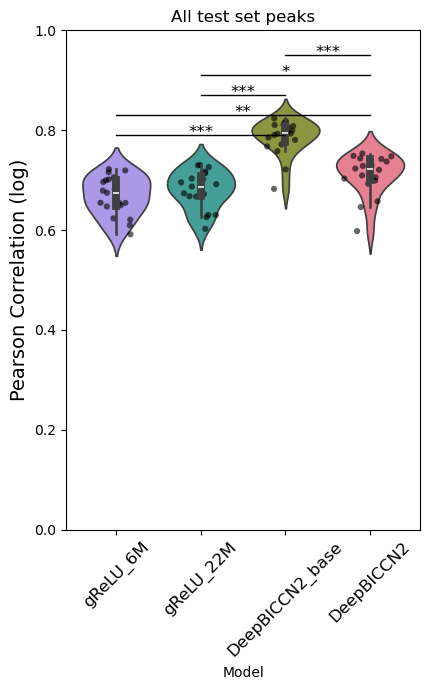

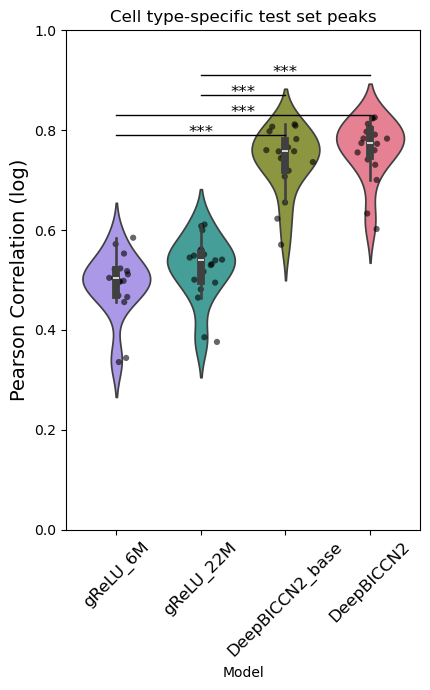

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

def plot_violin_metric_comparison(combined_df, metric_name, title='', selected_models=None, show_significance=True, savefig=None):
    """
    Plots a violin plot comparison of models for a given metric, with optional significance annotations.

    Parameters:
    - combined_df (pd.DataFrame): DataFrame with class-wise metrics for each model.
      Must include columns: 'Class', 'Model', metric_name.
    - metric_name (str): The name of the metric to compare.
    - selected_models (list): Optional list of model names to include in the plot. Defaults to all models.
    - show_significance (bool): Whether to show significance annotations. Defaults to True.

    Returns:
    - dict: Adjusted p-values for all pairwise comparisons (if `show_significance` is True).
    """
    # Filter data to include only selected models
    if selected_models:
        data = combined_df[combined_df['Model'].isin(selected_models)]
    else:
        data = combined_df
        selected_models = list(data['Model'].unique())

    # Prepare for pairwise t-tests if showing significance
    pval_dict = {}
    if show_significance:
        p_values = []
        comparisons = []
        metric_distributions = {}

        # Extract metric values for each model
        for model_name in selected_models:
            metric_distributions[model_name] = data[data['Model'] == model_name][metric_name].values

        # Perform pairwise t-tests between models
        for i, model1 in enumerate(selected_models):
            for j, model2 in enumerate(selected_models):
                if i < j:
                    stat, p = ttest_ind(
                        metric_distributions[model1],
                        metric_distributions[model2],
                        equal_var=False
                    )
                    p_values.append(p)
                    comparisons.append((model1, model2))

        # Adjust p-values for multiple comparisons
        _, adjusted_pvals, _, _ = multipletests(p_values, method="fdr_bh")

        # Create a dictionary for adjusted p-values
        pval_dict = {comparison: pval for comparison, pval in zip(comparisons, adjusted_pvals)}

    # Create the violin plot with scatter overlay
    plt.figure(figsize=(len(selected_models)*1.1, 7))
    sns.violinplot(
        x='Model',
        y=metric_name,
        data=data,
        inner='box',  # Show boxplot for quartiles
        density_norm='width',  # Ensures consistent width scaling
        hue='Model',  # Assign 'Model' to hue for compatibility with palette
        palette='husl',  # Seaborn's Set2 palette for distinct colors
        alpha=1,
        order=selected_models,
        legend=False  # Suppress legend for hue
    )

    # Overlay individual sample points as scatter points
    for i, model_name in enumerate(selected_models):
        model_data = data[data['Model'] == model_name][metric_name]
        x_vals = np.random.normal(loc=i, scale=0.1, size=len(model_data))  # Add slight jitter for better visibility
        plt.scatter(
            x_vals,
            model_data,
            color='black',
            alpha=0.6,
            s=20,
            edgecolors='none',  # Removes the border around dots
            label=None
        )

    #Add significance annotations if enabled
    if show_significance:
        line_offset = 0.04  # Space between annotation lines
        base_y_pos = 0.75  # Initial offset above the highest violin
    
        # Sort comparisons by model indices in logical order
        sorted_comparisons = sorted(
            zip(comparisons, adjusted_pvals),
            key=lambda x: (selected_models.index(x[0][0]), selected_models.index(x[0][1]))
        )
        increment=0
    
        # Plot significance lines
        for i, ((model1, model2), pval) in enumerate(sorted_comparisons):
            if pval < 0.05:
                increment+=1
                # Determine number of stars based on p-value
                if pval < 0.001:
                    stars = '***'
                elif pval < 0.01:
                    stars = '**'
                else:
                    stars = '*'
    
                # Get x positions of the models
                x1 = selected_models.index(model1)
                x2 = selected_models.index(model2)
    
                # Position the annotation above the highest violin for the two models
                y_max = max(
                    data[data['Model'] == model1][metric_name].max(),
                    data[data['Model'] == model2][metric_name].max()
                )
                y_pos = base_y_pos + increment * line_offset  # Increment for each line
    
                # Plot the horizontal line for the annotation
                plt.plot([x1, x2], [y_pos, y_pos], 'k-', lw=1)
    
                # Add the stars for significance
                plt.text(
                    (x1 + x2) / 2, y_pos-0.01,
                    stars,
                    ha='center', va='bottom', fontsize=12
            )

    # Customize the plot
    plt.ylabel(metric_name, fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    #plt.legend(loc='upper left', fontsize=12)
    plt.ylim([0,1])
    plt.title(title)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, bbox_inches='tight', dpi=300)
    plt.show()

    if show_significance:
        return pval_dict
    return None

print('')
pval_dict = plot_violin_metric_comparison(
    base_df,
    metric_name='Pearson Correlation (log)',
    selected_models=['gReLU_6M', 'gReLU_22M', 'DeepBICCN2_base', 'DeepBICCN2'],
    show_significance=True,
    title='All test set peaks'
    #savefig='paperfigs/base_comp_pearson_corr.pdf'
)
# Example usage
pval_dict = plot_violin_metric_comparison(
    specific_df,
    metric_name='Pearson Correlation (log)',
    selected_models=['gReLU_6M', 'gReLU_22M', 'DeepBICCN2_base', 'DeepBICCN2'],
    show_significance=True,
    title='Cell type-specific test set peaks'
    #savefig='paperfigs/base_comp_pearson_corr.pdf'
)



### Gene locus predictions

In [20]:
chrom = 'chr18'
start= 59175401
end= 59410446

ct='L6CT'
class_idx = list(adata.obs_names).index(ct)

upstream=50000
downstream=25000

strand= '+'

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    model=model,
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

I0000 00:00:1741955187.182026 3467660 service.cc:145] XLA service 0x7fdd04003990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741955187.182052 3467660 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-03-14 13:26:27.198175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-14 13:26:27.291153: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 222/3080 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step

I0000 00:00:1741955188.001419 3467660 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3080/3080 ━━━━━━━━━━━━━━━━━━━━ 3s 684us/step


In [21]:
bigwig = f"{DATA_DIR}coverage_bws/{ct}.bw"
values = crested.utils.read_bigwig_region(bigwig, (chrom,start-upstream,end+downstream)) if strand =='+' else crested.utils.read_bigwig_region(bigwig, (chrom,start-downstream,end+upstream))
bw_values=values[0]
midpoints=values[1]

#### Fig. 3e (top)

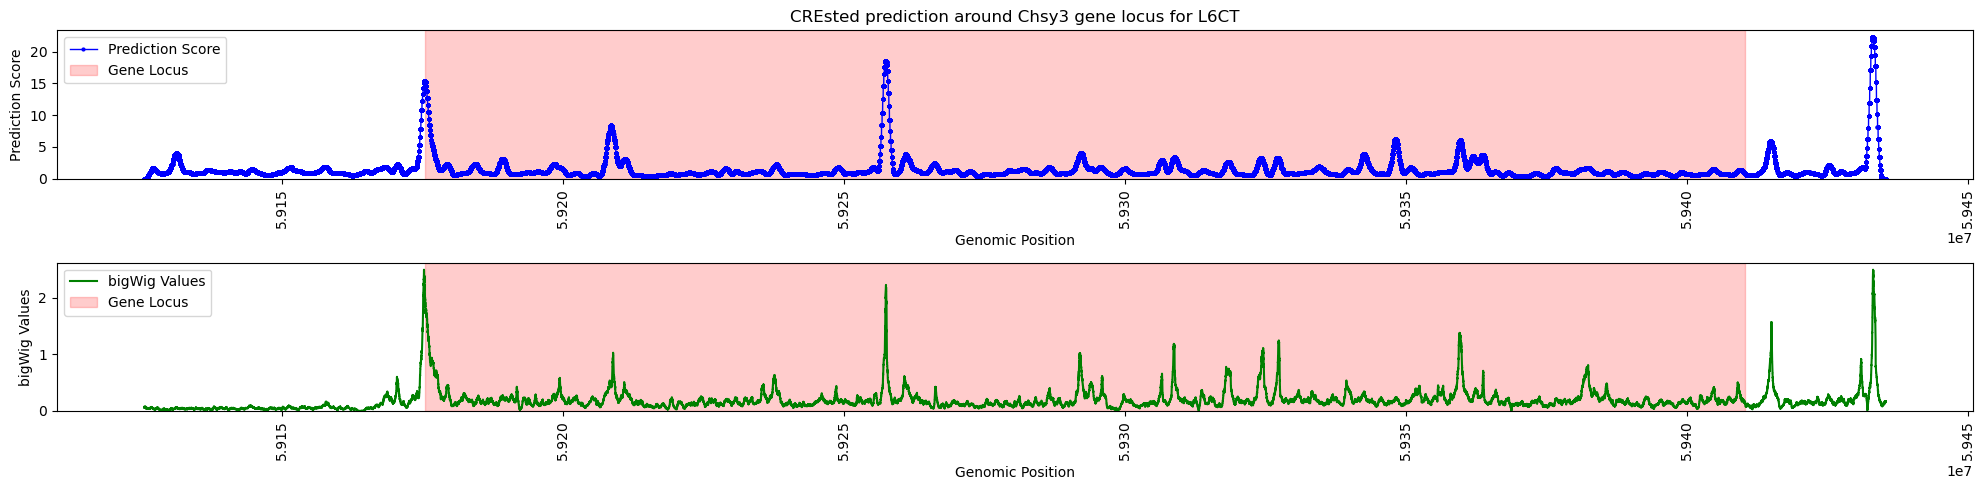

In [22]:
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Chsy3 gene locus for "+ct,
    #ylim=(0, 45),
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    grid=False,
    figsize=(20,5),
    marker_size=2,
    line_width=1,
    #filename='paperfigs/chsy3_locus.pdf'
)

In [23]:
import numpy as np
from scipy.stats import spearmanr, pearsonr

def calculate_correlations(array1, array2):
    """
    Calculate Spearman and Pearson correlations between two 1D arrays, including p-values.

    Parameters:
    - array1 (np.ndarray): First 1D array.
    - array2 (np.ndarray): Second 1D array.

    Returns:
    - dict: Spearman and Pearson correlation coefficients and p-values.
    """
    if len(array1) != len(array2):
        raise ValueError("Input arrays must have the same length.")

    # Pearson correlation
    pearson_corr, pearson_pval = pearsonr(array1, array2)

    # Spearman correlation
    spearman_corr, spearman_pval = spearmanr(array1, array2)

    return {
        "Pearson": {"correlation": pearson_corr, "p-value": pearson_pval},
        "Spearman": {"correlation": spearman_corr, "p-value": spearman_pval}
    }

results = calculate_correlations(scores, bw_values)

print("Pearson Correlation:", results["Pearson"]["correlation"])
print("Pearson p-value:", results["Pearson"]["p-value"])
print("Spearman Correlation:", results["Spearman"]["correlation"])
print("Spearman p-value:", results["Spearman"]["p-value"])

Pearson Correlation: 0.7527462733909778
Pearson p-value: 0.0
Spearman Correlation: 0.4817041639159846
Spearman p-value: 0.0


#### Cross-species chicken comparisons, Fig. 3e (bottom)

This analysis requires the galGal6 chicken genome. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html.

In [24]:
genome_chicken = "../../../chicken/galGal6.fa"

In [25]:
chrom = "chr10"
start = 20049223
end = 20076407

ct='Pvalb'
class_idx = list(adata.obs_names).index(ct)

upstream=50000
downstream=25000

strand= '-'

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    model=model,
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
    genome=genome_chicken
)

1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step


In [26]:
bigwig = f"{DATA_DIR}chicken_PVALB.bw" # From Hecker & Kempynck et al., 2025
values = crested.utils.read_bigwig_region(bigwig, (chrom,start-upstream,end+downstream)) if strand =='+' else crested.utils.read_bigwig_region(bigwig, (chrom,start-downstream,end+upstream))
bw_values=values[0]
midpoints=values[1]

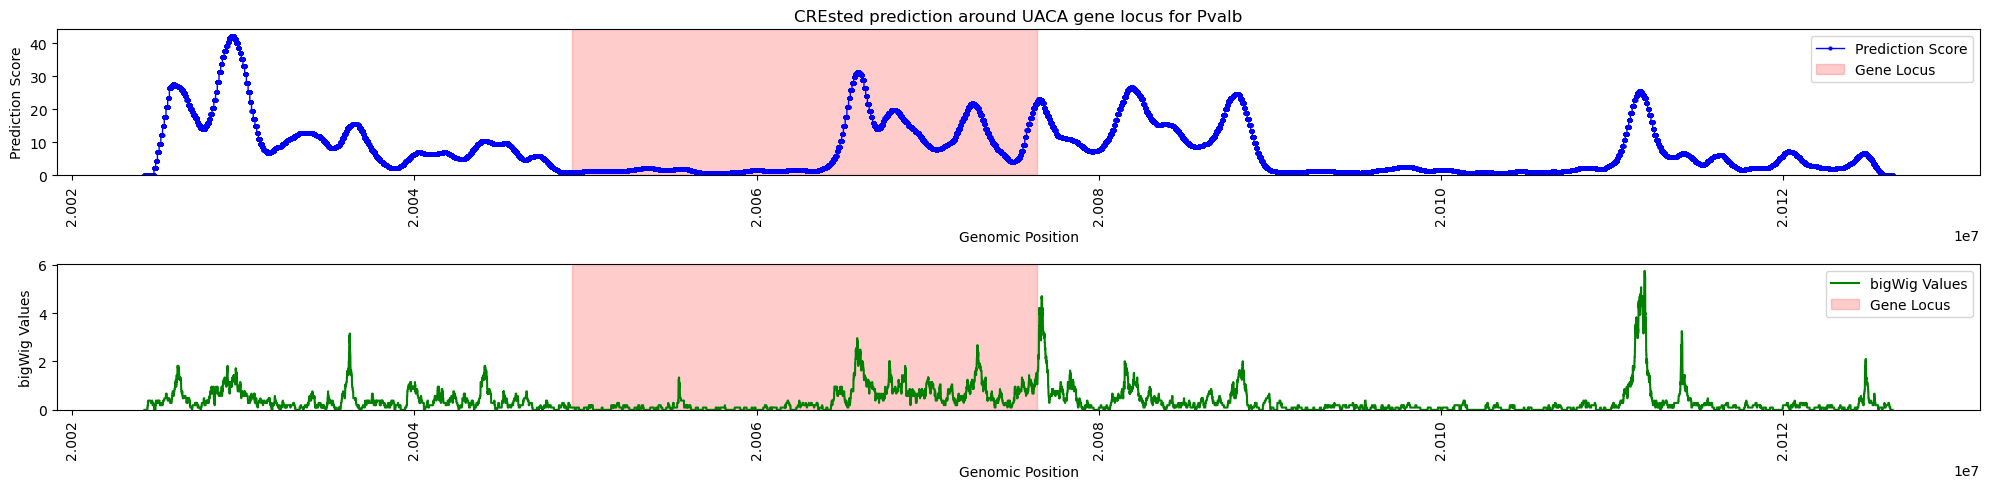

In [27]:
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around UACA gene locus for "+ct,
    #ylim=(0, 45),
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    grid=False,
    figsize=(20,5),
    marker_size=2,
    line_width=1,
    #filename='paperfigs/UACA_locus.pdf'
)

## Modisco analysis
Same as in main CREsted enhancer_code_analysis.ipynb notebook.

In [28]:
# First we obtain the resulting modisco files per class
matched_files = crested.tl.modisco.match_h5_files_to_classes(
    contribution_dir=f"{DATA_DIR}mouse_cortex_modisco", classes=list(adata.obs_names)
)

In [29]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=4.25,  # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from tangermeme
    trim_ic_threshold=0.05,#0.025,  # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2,  # IC threshold used for discarding single instance patterns
    verbose=True,  # Useful for doing sanity checks on matching patterns
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(adata.obs_names), all_patterns=all_patterns, normalize=False, pattern_parameter='seqlet_count_log'
)
pattern_matrix.shape

Reading file ../../../crested_data/Figure_2/mouse_cortex_modisco/Astro_modisco_results.h5
Match between Astro_pos_patterns_1 and Astro_neg_patterns_4 with similarity score 4.83
Match between Astro_pos_patterns_11 and Astro_pos_patterns_5 with similarity score 7.19
Match between Astro_pos_patterns_14 and Astro_pos_patterns_8 with similarity score 4.80
Match between Astro_pos_patterns_15 and Astro_pos_patterns_3 with similarity score 7.44
Reading file ../../../crested_data/Figure_2/mouse_cortex_modisco/Endo_modisco_results.h5
Match between Endo_neg_patterns_0 and Astro_neg_patterns_0 with similarity score 4.44
Match between Endo_pos_patterns_1 and Astro_pos_patterns_3 with similarity score 7.06
Match between Endo_pos_patterns_7 and Astro_neg_patterns_2 with similarity score 5.45
Match between Endo_pos_patterns_11 and Endo_pos_patterns_7 with similarity score 5.20
Reading file ../../../crested_data/Figure_2/mouse_cortex_modisco/L2_3IT_modisco_results.h5
Match between L2_3IT_neg_patterns_2

(19, 108)

### Fig. 2g

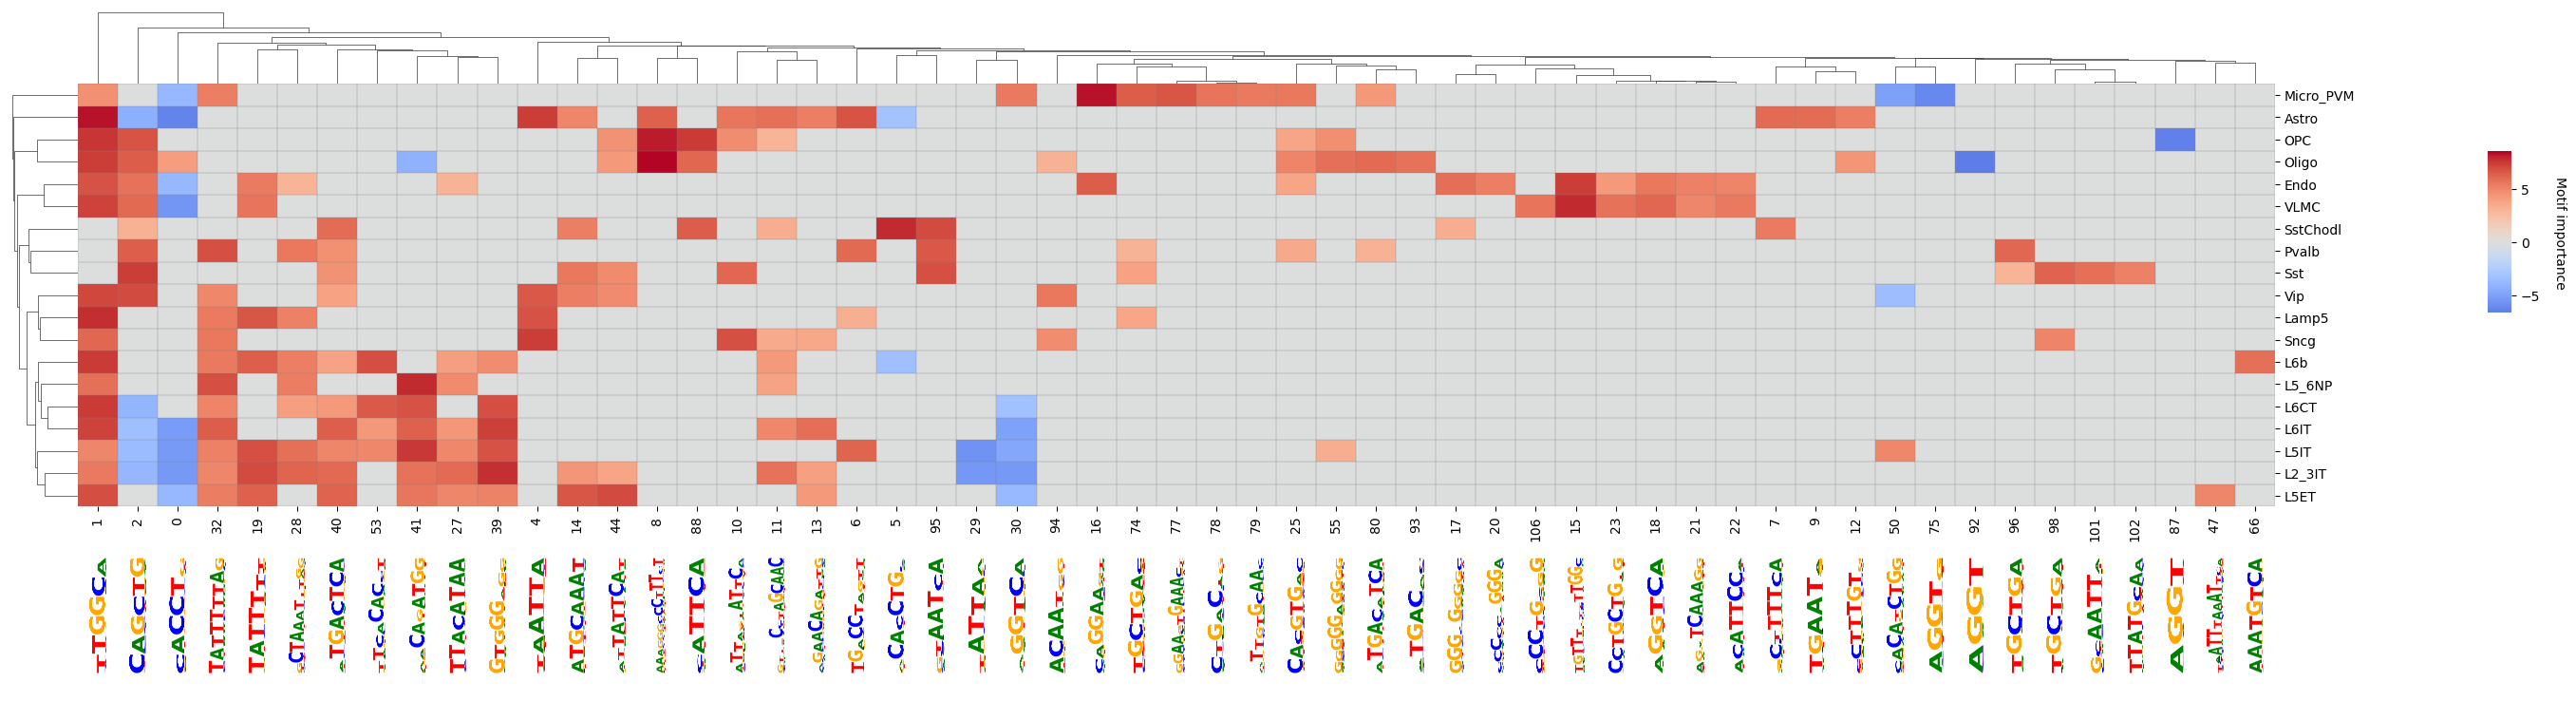

In [30]:
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(adata.obs_names),
    pattern_dict=all_patterns,
    figsize=(25, 4.2),
    grid=True,
    dendrogram_ratio=(0.03,0.15),
    importance_threshold=5,#3.5,
    logo_height_fraction = 0.35,  
    logo_y_padding=0.25,
    #fig_path='paperfigs/motif_clusters_logos_MO.pdf'
)

### TF candidate matching

In [31]:
import crested
file_path = f"{DATA_DIR}/mouse_cortex_scrna.h5ad"  # Locate h5 file containing scRNAseq data
cell_type_column = "subclass_Bakken_2022"
mean_expression_df = crested.tl.modisco.calculate_mean_expression_per_cell_type(
    file_path, cell_type_column, cpm_normalize=True
)

/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/tl/modisco/_tfmodisco.py:1390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression_per_cell_type: pd.DataFrame = gene_expression_df.groupby(


In [32]:
classes = list(adata.obs_names)
contribution_dir = f"{DATA_DIR}mouse_cortex_modisco"
html_paths = crested.tl.modisco.generate_html_paths(
    all_patterns, classes, contribution_dir
)

pattern_match_dict = crested.tl.modisco.find_pattern_matches(
    all_patterns, html_paths, q_val_thr=0.05
)  # q_val threshold to only select significant matches
print(pattern_match_dict['2']['matches'])

['transfac_pro__M07465', 'flyfactorsurvey__crp_SANGER_10_FBgn0001994', 'hocomoco__PTF1A_HUMAN.H11MO.1.B', 'transfac_pro__M07465', 'flyfactorsurvey__crp_SANGER_10_FBgn0001994', 'hocomoco__PTF1A_HUMAN.H11MO.1.B', 'homer__NAACAGCTGG_Tcf21', 'transfac_pro__M10439', 'kznf__ZBTB18_Schmitges2016_RCADE', 'transfac_pro__M07465', 'flyfactorsurvey__crp_SANGER_10_FBgn0001994', 'hocomoco__PTF1A_HUMAN.H11MO.1.B', 'homer__NAACAGCTGG_Tcf21', 'transfac_pro__M10439', 'kznf__ZBTB18_Schmitges2016_RCADE', 'tfdimers__MD00535', 'cisbp__M01163', 'transfac_pro__M07465', 'flyfactorsurvey__crp_SANGER_10_FBgn0001994', 'hocomoco__PTF1A_HUMAN.H11MO.1.B', 'homer__NAACAGCTGG_Tcf21', 'transfac_pro__M10439', 'kznf__ZBTB18_Schmitges2016_RCADE', 'tfdimers__MD00535', 'cisbp__M01163', 'transfac_pro__M10439', 'kznf__ZBTB18_Schmitges2016_RCADE', 'cisbp__M00588', 'transfac_pro__M07465', 'flyfactorsurvey__crp_SANGER_10_FBgn0001994', 'hocomoco__PTF1A_HUMAN.H11MO.1.B', 'homer__NAACAGCTGG_Tcf21', 'transfac_pro__M10439', 'kznf__ZB

In [33]:
motif_to_tf_df = crested.tl.modisco.read_motif_to_tf_file(
    f"{DATA_DIR}motif_collection.tsv"
)
motif_to_tf_df

,logo,Motif_name,Cluster,Human_Direct_annot,Human_Orthology_annot,Mouse_Direct_annot,Mouse_Orthology_annot,Fly_Direct_annot,Fly_Orthology_annot,Cluster_Human_Direct_annot,Cluster_Human_Orthology_annot,Cluster_Mouse_Direct_annot,Cluster_Mouse_Orthology_annot,Cluster_Fly_Direct_annot,Cluster_Fly_Orthology_annot
0,"<img src=""https://motifcollections.aertslab.org/v10/logos/bergman__Adf1.png"" height=""52"" alt=""bergman__Adf1""></img>",bergman__Adf1,NaN,NaN,NaN,NaN,NaN,Adf1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"<img src=""https://motifcollections.aertslab.org/v10/logos/bergman__Aef1.png"" height=""52"" alt=""bergman__Aef1""></img>",bergman__Aef1,NaN,NaN,NaN,NaN,NaN,Aef1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"<img src=""https://motifcollections.aertslab.org/v10/logos/bergman__ap.png"" height=""52"" alt=""bergman__ap""></img>",bergman__ap,NaN,NaN,NaN,NaN,NaN,ap,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"<img src=""https://motifcollections.aertslab.org/v10/logos/elemento__ACCTTCA.png"" height=""52"" alt=""elemento__ACCTTCA""></img>",elemento__ACCTTCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"<img src=""https://motifcollections.aertslab.org/v10/logos/bergman__bcd.png"" height=""52"" alt=""bergman__bcd""></img>",bergman__bcd,NaN,NaN,NaN,NaN,NaN,bcd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22471,"<img src=""https://motifcollections.aertslab.org/v10/logos/elemento__CAAGGAG.png"" height=""52"" alt=""elemento__CAAGGAG""></img>",elemento__CAAGGAG,98.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22472,"<img src=""https://motifcollections.aertslab.org/v10/logos/elemento__TCCTTGC.png"" height=""52"" alt=""elemento__TCCTTGC""></img>",elemento__TCCTTGC,98.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22473,"<img src=""https://motifcollections.aertslab.org/v10/logos/swissregulon__hs__ZNF274.png"" height=""52"" alt=""swissregulon__hs__ZNF274""></img>",swissregulon__hs__ZNF274,99.1,ZNF274,NaN,NaN,"Zfp369, Zfp110",NaN,NaN,ZNF274,NaN,NaN,"Zfp369, Zfp110",NaN,NaN
22474,"<img src=""https://motifcollections.aertslab.org/v10/logos/swissregulon__sacCer__THI2.png"" height=""52"" alt=""swissregulon__sacCer__THI2""></img>",swissregulon__sacCer__THI2,99.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
cols = [
    "Mouse_Direct_annot",
    "Mouse_Orthology_annot",
    "Cluster_Mouse_Direct_annot",
    "Cluster_Mouse_Orthology_annot",
]
pattern_tf_dict, all_tfs = crested.tl.modisco.create_pattern_tf_dict(
    pattern_match_dict, motif_to_tf_df, all_patterns, cols
)
tf_ct_matrix, tf_pattern_annots = crested.tl.modisco.create_tf_ct_matrix(
    pattern_tf_dict,
    all_patterns,
    mean_expression_df,
    classes,
    log_transform=True,
    normalize_pattern_importances=False,
    normalize_gex=True,
    min_tf_gex=0.95,
    importance_threshold=5.5,
    pattern_parameter='seqlet_count_log',
    filter_correlation=True,
    verbose=True,
    zscore_threshold=1.5,
    correlation_threshold=0.35,
)

Total columns before threshold filtering: 989
Total columns after threshold filtering: 149
Total columns removed: 840
Total columns before correlation filtering: 149
Total columns after correlation filtering: 103
Total columns removed: 46


#### Fig. 2h

/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/pl/patterns/_modisco_results.py:897: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


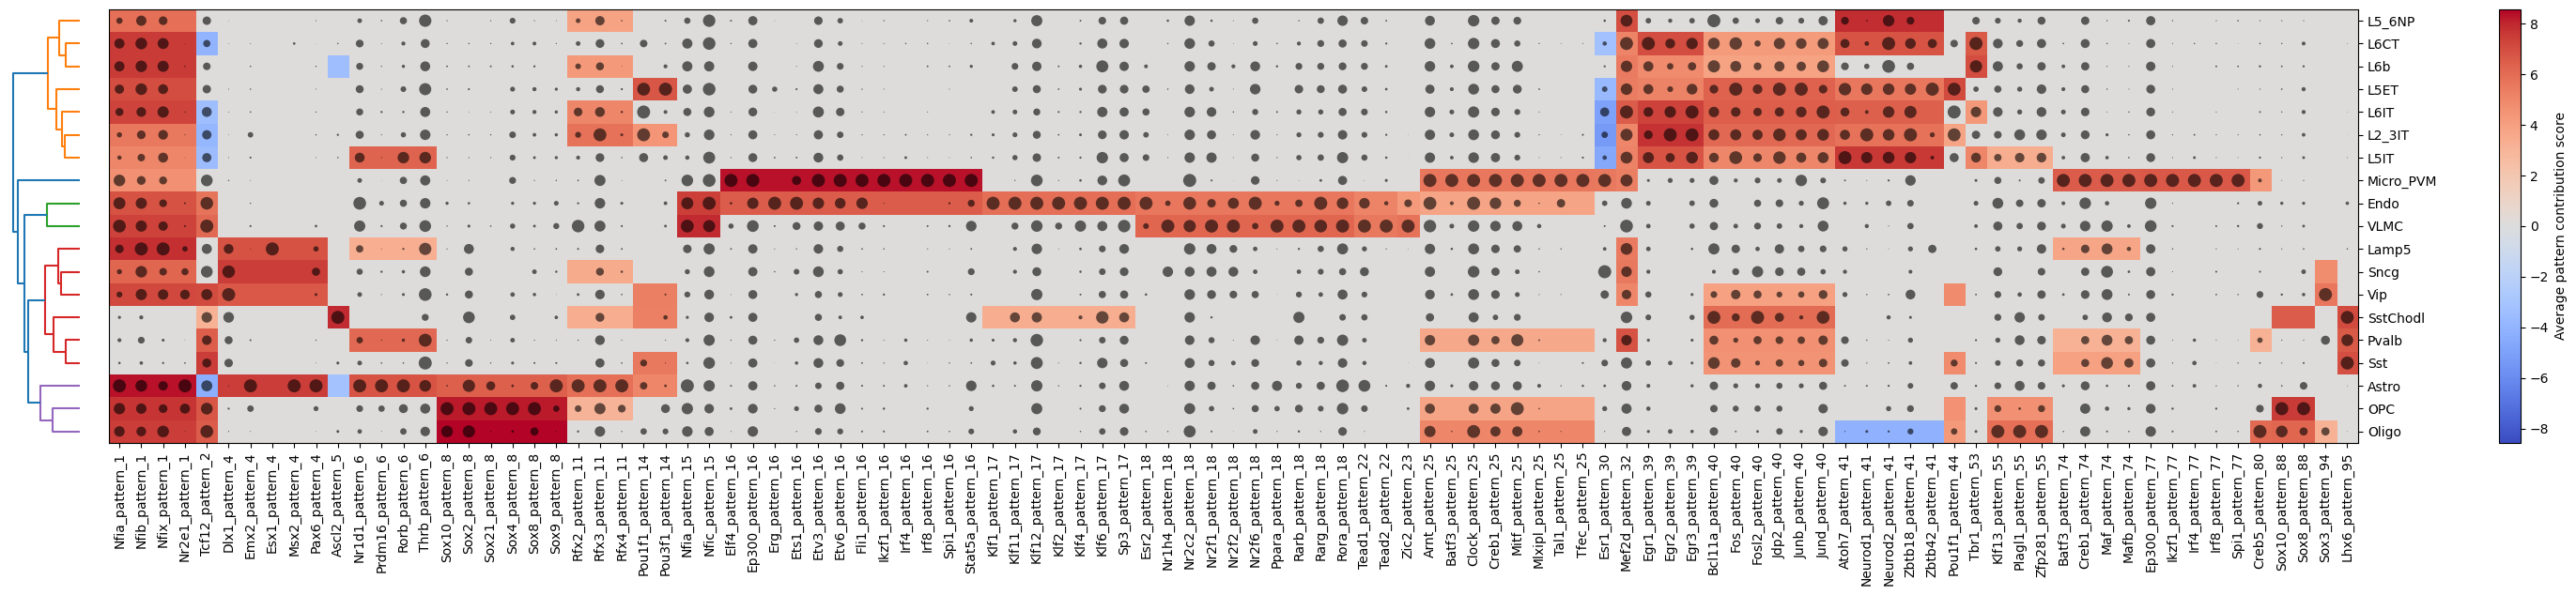

In [35]:
crested.pl.patterns.clustermap_tf_motif(
    tf_ct_matrix,
    heatmap_dim='contrib',
    dot_dim='gex',
    class_labels=classes,
    pattern_labels=tf_pattern_annots,
    fig_size=(40,6),
    cluster_rows=True,
    cluster_columns=False,
    #save_path='paperfigs/tf_clusters_v2.pdf'
)